In [1]:
import os
import copy
import pickle
import warnings
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import bootstrap

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import palettable
import deepdish as dd

from astropy.utils.console import ProgressBar
from astropy.table import QTable
plt.rc('text', usetex=True)
rcParams.update({'axes.linewidth': 1.5})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.minor.visible': 'True'})
rcParams.update({'ytick.minor.visible': 'True'})
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '8.0'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '4.0'})
rcParams.update({'xtick.minor.width': '1.5'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '8.0'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '4.0'})
rcParams.update({'ytick.minor.width': '1.5'})
rcParams.update({'axes.titlepad': '10.0'})
rcParams.update({'font.size': 30})

In [2]:
data_dir="/Users/xushuo/work/Submit/Simulation/data/"
fig_dir="/Users/xushuo/work/Papers/Simulation/Figure/"

In [67]:
cmap1=palettable.colorbrewer.sequential.Greys_4.mpl_colormap

In [3]:
tab=dd.io.load(data_dir+'galaxies_tng300_072.hdf5','/physical_mass')

In [4]:
mask_xy=(tab['catsh_primary']==True)&(tab['proj']=='xy')&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.6)
mask_yz=(tab['catsh_primary']==True)&(tab['proj']=='yz')&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.6)
mask_xz=(tab['catsh_primary']==True)&(tab['proj']=='xz')&(tab['mass_stellar_ins']>1e10)&(tab['mass_stellar_exs']>10**10.6)

In [28]:
mask0=(tab[mask_xy]['ellipticity']-tab[mask_yz]['ellipticity']<-0.45)

In [69]:
def draw_arrow(ax, arr_start, arr_end):
    dx = arr_end[0] - arr_start[0]
    dy = arr_end[1] - arr_start[1]
    ax.arrow(arr_start[0], arr_start[1], dx, dy, head_width=0.05, head_length=0.05, length_includes_head=True, color='red')

In [60]:
def arrowplot(ax,x1,x2,y):
    for i in range(len(x1)):
        draw_arrow(ax,[x1[i],y[i]],[x2[i],y[i]])

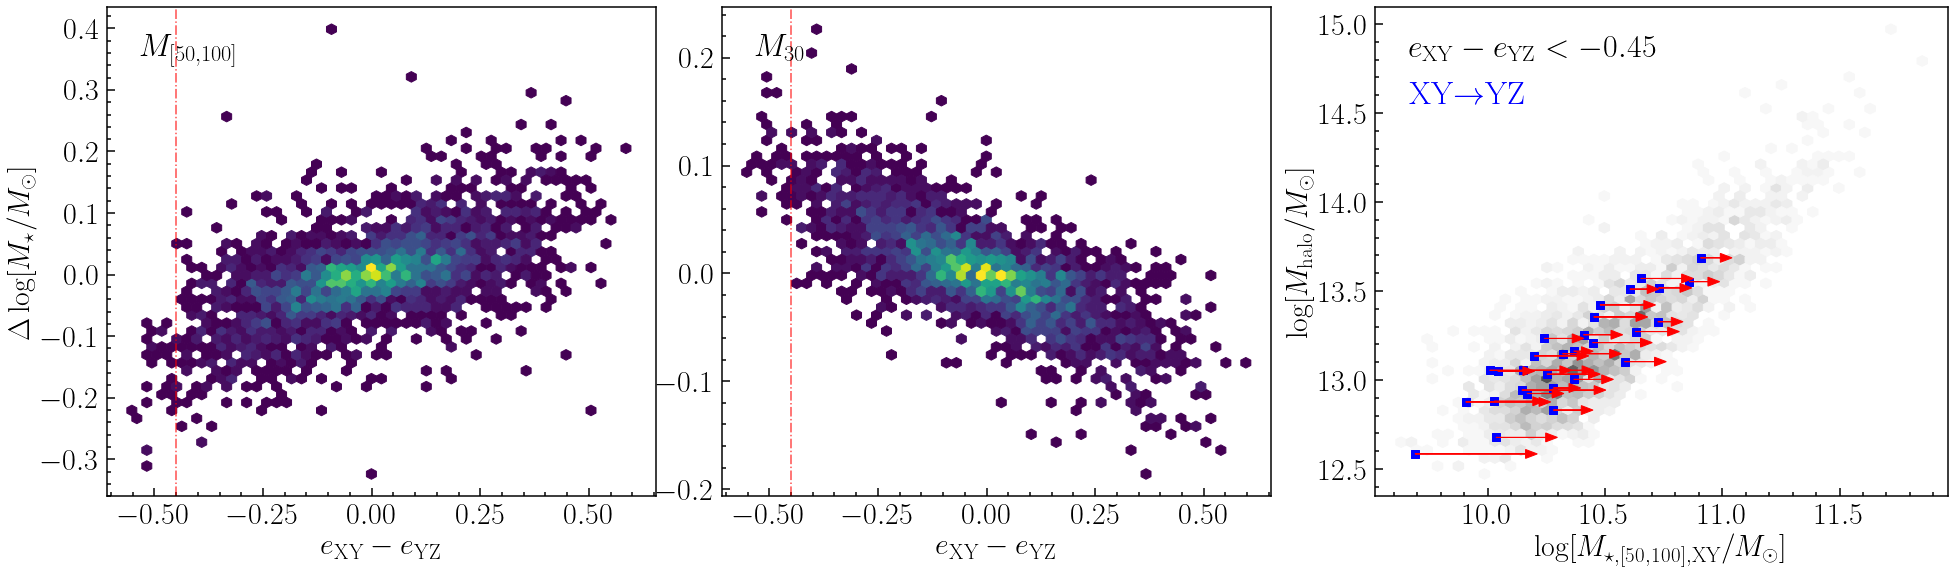

In [70]:
fig=plt.figure(figsize=(33, 9))
gs = fig.add_gridspec(1,2, hspace=0, wspace=0.12,width_ratios=(0.67,0.33))
inner_grid=gs[0,0].subgridspec(1,2,hspace=0, wspace=0.12)
(ax1,ax2)=inner_grid.subplots(sharex='col')
ax3=gs[0,1].subgridspec(1,1,hspace=0, wspace=0).subplots(sharex='col', sharey='row')


ax1.hexbin((tab[mask_xy]['ellipticity']-tab[mask_yz]['ellipticity']),(np.log10(tab[mask_xy]['aper_100_gal']-tab[mask_xy]['aper_30_gal'])-np.log10(tab[mask_yz]['aper_100_gal']-tab[mask_yz]['aper_30_gal'])),gridsize=50,mincnt=1)
ax1.set_ylabel(r'$\Delta\log[M_{\star}/M_\odot]$')
ax1.set_xlabel(r'$e_{\rm XY}-e_{\rm YZ}$')

ax2.hexbin((tab[mask_xy]['ellipticity']-tab[mask_yz]['ellipticity']),(np.log10(tab[mask_xy]['aper_30_gal'])-np.log10(tab[mask_yz]['aper_30_gal'])),gridsize=50,mincnt=1)
ax2.set_xlabel(r'$e_{\rm XY}-e_{\rm YZ}$')

ax1.axvline(x=-0.45,linestyle='-.',color='red',alpha=0.7)
ax2.axvline(x=-0.45,linestyle='-.',color='red',alpha=0.7)
ax1.text(0.06, 0.90, r'$M_{[50,100]}$', transform=ax1.transAxes, size=32)
ax2.text(0.06, 0.90, r'$M_{30}$', transform=ax2.transAxes, size=32)

ax3.hexbin(np.log10(tab[mask_xy]['aper_100_gal']-tab[mask_xy]['aper_50_gal']),np.log10(tab[mask_xy]['mass_halo']),cmap=cmap1,gridsize=50,mincnt=1)
ax3.scatter(np.log10(tab[mask_xy][mask0]['aper_100_gal']-tab[mask_xy][mask0]['aper_50_gal']),np.log10(tab[mask_xy][mask0]['mass_halo']),c='blue',s=60,marker='s',label=r'\rm XY')
#ax3.scatter(np.log10(tab[mask_yz][mask0]['aper_100_gal']-tab[mask_yz][mask0]['aper_50_gal']),np.log10(tab[mask_yz][mask0]['mass_halo']),c='black',s=60,marker='o',label=r'\rm YZ')
arrowplot(ax3,np.log10(tab[mask_xy][mask0]['aper_100_gal']-tab[mask_xy][mask0]['aper_50_gal']),
          np.log10(tab[mask_yz][mask0]['aper_100_gal']-tab[mask_yz][mask0]['aper_50_gal']),
          np.log10(tab[mask_yz][mask0]['mass_halo']))
ax3.set_xlabel(r'$\log[M_{\star,[50,100],{\rm XY}}/M_\odot]$')
ax3.set_ylabel(r'$\log[M_{\rm halo}/M_\odot]$')
ax3.text(0.06, 0.90, r'$e_{\rm XY}-e_{\rm YZ}<-0.45$', transform=ax3.transAxes, size=32)
ax3.text(0.06, 0.80, r'\rm XY$\rightarrow$YZ', transform=ax3.transAxes, size=32,color='blue')
#ax3.legend(fontsize=28)
plt.savefig(fig_dir+"Fig8.png",dpi=350)